In [89]:
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import networkx as nx
from itertools import combinations


In [90]:
# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("perspectiva-solution/embeddings-gdn-question-163")['train']
df = ds.to_pandas()
df = df[df.cluster_id != -1].sample(n=10000, random_state=1234) # Remove idea which were not clustered

In [91]:
G = nx.Graph()
G.add_nodes_from(df.contribution_id) # A node is a contribution

# Add edge if two nodes belong to the same cluster
for title, subdf in df.groupby("cluster_title"):
    edges = tuple(combinations(subdf.contribution_id.to_list(), 2))
    for edge in edges:
        if G.has_edge(*edge):
            G.edges[*edge]["weight"] += 1
        else:
            G.add_edge(*edge, weight=1)

In [92]:
partition = nx.community.louvain_communities(
    G, weight="weight", resolution=1, seed=2025
)

In [93]:
# Big partitions could be personas
personas = []
threshold = len(df) // 100
for node_set in partition:
    if len(node_set) >= threshold:
        personas.append(node_set)


In [94]:
def return_IoU(node_i, node_j):
    contributions_i = personas[node_i]
    contributions_j = personas[node_j]

    demands_i = df.loc[df.contribution_id.isin(contributions_i), "cluster_title"].unique()
    demands_j = df.loc[df.contribution_id.isin(contributions_j), "cluster_title"].unique()
    intersection = set(demands_i).intersection(set(demands_j))
    union = set(demands_i).union(set(demands_j))
    return len(intersection) / len(union)


In [95]:
# Graph of Louvain communities
H = nx.Graph()
H.add_nodes_from(range(len(personas)))

weights = []
for node_pair in combinations(H.nodes, 2):
    iou = return_IoU(*node_pair)
    weights.append(iou)
    if iou >= 0.1:  
        H.add_edge(
            *node_pair,
            value=iou,
            #title="\n".join(return_intersection(1, 2))
        )

In [96]:
np.quantile(weights, q=0.50)

np.float64(0.058823529411764705)

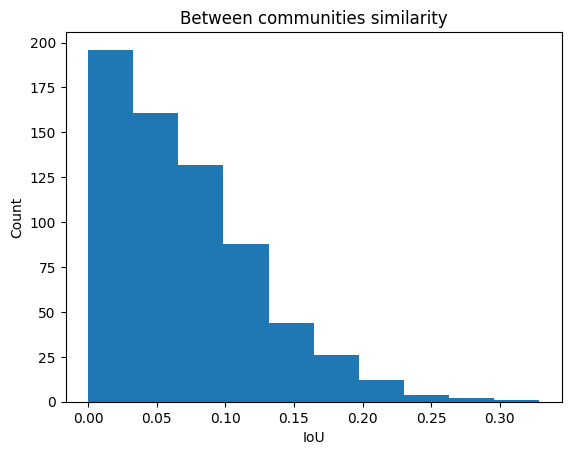

In [97]:
plt.hist(np.array(weights))
plt.title("Between communities similarity")
plt.xlabel("IoU")
plt.ylabel("Count")
plt.show()

In [98]:
def characterize_node(idx):
    """Return common contributions of the community

    Args:
        idx (_type_): _description_
    """
    msk = df.contribution_id.isin(personas[idx])
    community_demands = list(df[msk].groupby("cluster_id")["cluster_title"].unique())
    community_demands = df[msk].groupby("cluster_title")["cluster_title"].count()
    return (community_demands / community_demands.sum()).sort_values(ascending=False)

    
def make_title(demands, topk=5):
    title = ""
    for row_idx in range(topk):
        row_value = demands.iloc[row_idx]
        demand = demands.index[row_idx]
        title += f"{demand} ({row_value * 100:.2f}%)\n"
    return title


In [99]:
# TODO Get links between communities
for community in H.nodes:
    community_demands = characterize_node(community)
    H.nodes[community]["title"] = make_title(community_demands)
    H.nodes[community]["size"] = len(personas[community]) // 10

In [101]:
from pyvis.network import Network
nt = Network("500px", "500px")
nt.repulsion()
nt.from_nx(H)
nt.toggle_physics(True)
nt.show_buttons(filter_=["physics"])
nt.show("communities.html", notebook=False)

communities.html
